### Prerequisites

+  A fork of the sysidentpy code is needed to get this thing up and running. 

+ Please clone the [code](https://github.com/robotsorcerer/sysidentpy) to the root folder of `robust-design` in your root directory. 

+ We should be good to go.

In [1]:
import copy 
import scipy
import numpy as np
import pandas as pd

import scipy.linalg as sla 
from scipy.signal import place_poles
import numpy.linalg as la 
import matplotlib.pyplot as plt

from scipy.linalg import solve_continuous_are as CARE

# Make sure we can import required slycot routine
try:
    from slycot import sg02ad
except ImportError:
    raise print("Can't find slycot module 'sg02ad'") 
    
import sys, os 

sys.path.append("..")
sys.path.append("../../sysidentpy")
from utils import *
from dynsys import * 
from linearsys import * 
from identify import * 
from hinfinity import * 
from multiprocessing import Pool

from sysidentpy.narmax_base import InformationMatrix
from sysidentpy.model_structure_selection import (FROLS, FROLS2)
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

### Generating a 3-input-1-output sampled data from a car cruise control model

$$
m \dfrac{dv}{dt} = \alpha_n u T (\alpha_n v) - m g C_r sgn(u) - \dfrac{1}{2} \rho C_d A |v| v - mg \sin \theta
$$

where 

+ $v$ is the velocity profile of the vehicle, aka the state;
+ $m$ is the mass of the vehicle;
+ $\alpha_n$ is the effective wheel radius of the vehicle;
+ $T$ is the vehicle's torque, 
    + controlled by the throttle $u$;
+ $C_r$ is the rolling friction coefficient;
+ $C_d$ is the aerodynamic drag constant for a vehicle of area $A$;
+ $\theta$ is the road curvature, modeled as a Wiener process;

This model is adopted from R.M. Murray's Feedback Systems book, section 4.1.


Let $x := v, \, u_1 := u, \, u_2:= \alpha_n$, and $u_3 := \theta$. Then, The state space equation is

\begin{align}
m \dot{x} &= u_2 u_1 T(u_1 x) - mg C_r sgn(u_1) - \dfrac{1}{2} \rho C_d A |x| x - mg \sin u_3  \\
  \dot{x} &= m^{-1} u_2 u_1 T(u_1 x) - g C_r sgn(u_1) - \dfrac{1}{2} m^{-1} \rho C_d A |x| x - g \sin u_3 
\end{align}

The torque $T$ is given by 

$$
T = T_m \left(1-\beta\left(\dfrac{\omega}{\omega_m}-1\right)^2\right)
$$

where $\beta = 0.4, \omega_m = 420$ and $T_m = 190$, so that we have 

$$
T = 190\left(1 - 0.4 \left(\dfrac{39 x}{420}-1\right)^2 \right) = 190 - 76 \left(\dfrac{39 x}{420}-1\right)^2.
$$

The true model used in data collection is given as

\begin{align}
  \dot{x} &= 0.000625 u_1 u_2 T(u_1 x) - 0.098 sgn(u_1) - 0.000312 |x| x - 9.8 \sin u_3 
\end{align}


### Get the profile of car's inputs and acceleratin throughout travel time.

In [16]:
show = False
cruiser = CruiseControlModel(n=1, m=3, d=1)
u, x = cruiser.data_collect(ndata=16000)
u, x = u, np.expand_dims(x, 1)

from os.path import join, expanduser 

if show:
    font = {'weight' : 'bold',
            'size'   : 22}

    T = np.linspace(0, x.size, x.size)

    # show me what you got
    fontdict = {"fontsize":18, "fontweight":"bold"}
    colors = ["red", "purple", "brown", "blue"]
    fig, ax = plt.subplots(1, 2, figsize=(25,9))
    legends = [rf"Car speed $(m/s^2)$", "Gear ratio", "Road curvature (deg)"]
    titles = [rf"Identification Signal: $u_{{ref}}$", rf"Identification Signal: $\alpha_n$", rf"Identification Signal: $\theta$"]
    i = 0
    for idx in [0, 2]: #range(u.shape[0]):
        ax[i].plot(T/100, u[idx], label=rf"$u_{idx+1}$: {legends[idx]}", color=colors[idx], linewidth=6)
        ax[i].legend(loc="best", fontsize=22)
        ax[i].set_xlabel(rf"Time ($\times$ 100 secs)", fontdict=fontdict)
        ax[i].xaxis.set_tick_params(labelsize=24)
        ax[i].yaxis.set_tick_params(labelsize=24)
        ax[i].grid("on")
        ax[i].set_title(titles[idx], fontdict = font)
        i += 1
    ax[1].yaxis.set_ticks([])
    plt.savefig(join(expanduser("~"),"Documents/Papers/Pubs22/IFAC/figures", "ident_inputs.eps"), dpi=79, facecolor=None)

    plt.figure(figsize=(25,9))
    plt.plot(T/100, x/1000, label=rf"$x(v)$: Car acceleration $(Km/s^2)$", color="blue", linewidth=8)
    plt.xlabel(rf"Time ($\times$ 100 secs)", fontdict=fontdict)
    plt.ylabel(rf"Acceleration (m/s$^2$)", fontdict=fontdict)
    plt.gca().xaxis.set_tick_params(labelsize=24)
    plt.gca().yaxis.set_tick_params(labelsize=24)
    plt.legend(loc="upper right", fontsize=24)
    plt.grid("on")
    plt.savefig(join(expanduser("~"),"Documents/Papers/Pubs22/IFAC/figures", "ident_output.eps"), dpi=79, facecolor=None)
    plt.show()

u = u.T

### Do a NARMAX Identification from I/O data

In [17]:

ratio = int(0.8*len(u))
x_train, y_train = u[:ratio], x[:ratio]
x_test,  y_test  = u[ratio:], x[ratio:]

xlag, ylag =[1, 1, 1], 1

degree = 3
cruise_func = CruiseControlBasis(xlag, ylag, noise_var=1e-5, degree=degree, ensemble=False)

frols_model = FROLS2(
    order_selection=False,
    n_terms=4,
    n_info_values=4,
    extended_least_squares=False,
    ylag=ylag, xlag=xlag,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=cruise_func
)

# get regression matrix from Cruise Control Model Basis Class
P_matrix = cruise_func.fit(X=x_train, y=y_train)

print("reg_matrix: ", P_matrix.shape)
    
# Estimate the Theta parameters based on calculated Reg. Matrix
frols_model.fit(X=x_train, y=y_train, reg_matrix=P_matrix)
theta = frols_model.theta 
print()

reg_matrix:  (12799, 35)



### Model Evaluation 

In [18]:
# make predictions based on test data
yhat = cruise_func.predict(x_test, y_test[:frols_model.max_lag], frols_model.pivv, frols_model.final_model , 
                            frols_model.xlag, frols_model.ylag, frols_model.max_lag, theta=theta, horizon=None)

rrse = root_relative_squared_error(y_test, yhat)
print('rrse ', rrse)

r = pd.DataFrame(
    results(
        frols_model.final_model, frols_model.theta, frols_model.err,
        frols_model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)
# plot_results(y=y_test, yhat = yhat, n=10000)
ee = compute_residues_autocorrelation(y_test, yhat)
# plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
# x1e = compute_cross_correlation(y_test, yhat, x_test[:, 0])
# plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

rrse  0.06521536815152773
         Regressors   Parameters             ERR
0   x2(k-1)^2y(k-1)   6.2518E-02  9.99999925E-01
1  x2(k-1)^2x1(k-1)  -1.2077E-01  2.14658136E-09
2   x2(k-1)y(k-1)^2   5.6685E-10  3.72143838E-10
3         x2(k-1)^3   8.1204E-03  1.73993889E-11


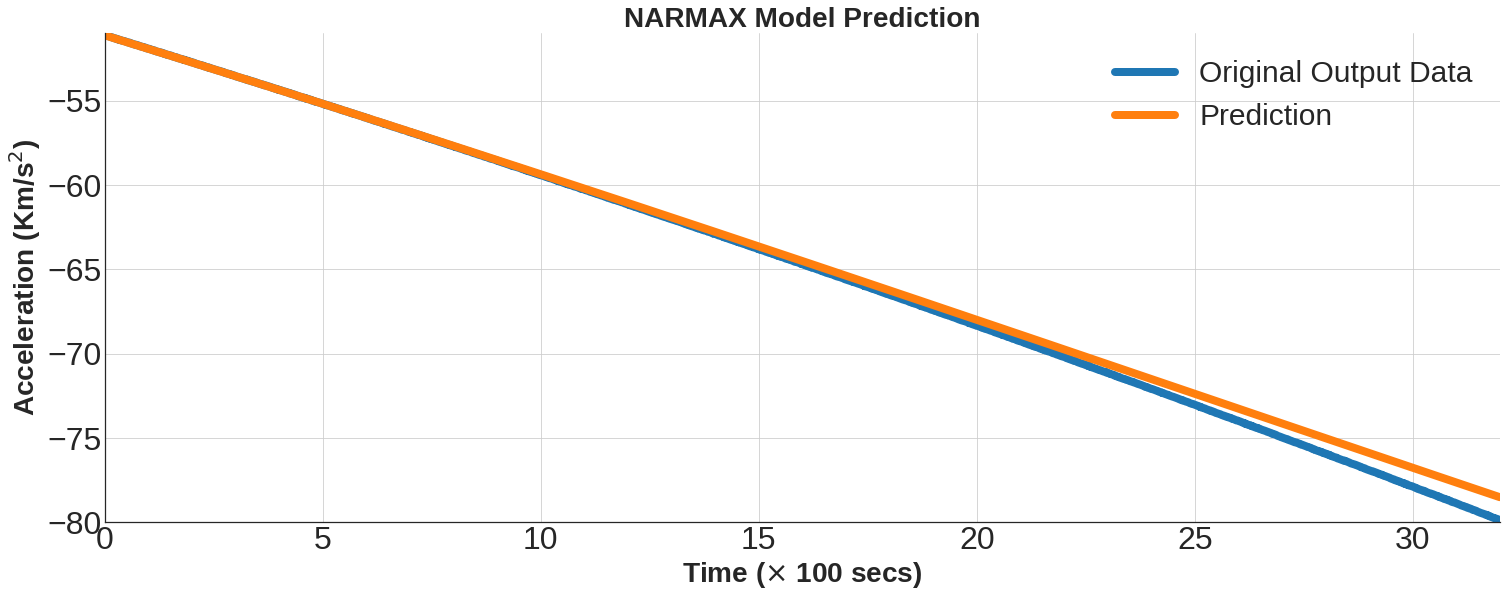

In [19]:
plt.figure(figsize=(25,9),  facecolor="white")
T = np.linspace(0, y_test.size, y_test.size)
fontdict = dict(weight='bold', size=28)

plt.plot(T/100, y_test/1000, label=rf"Original Output Data", color="#1f77b4", linewidth=8)
plt.plot(T/100, yhat/1000, label=rf"Prediction", color="#ff7f0e", linewidth=8)
plt.title("NARMAX Model Prediction", fontdict=fontdict)
plt.xlabel(rf"Time ($\times$ 100 secs)", fontdict=fontdict)
plt.ylabel(rf"Acceleration (Km/s$^2$)", fontdict=fontdict)
plt.ylim([-80, -51])
plt.xlim([0, 32])
plt.gca().xaxis.set_tick_params(labelsize=32)
plt.gca().yaxis.set_tick_params(labelsize=32)
plt.legend(loc="upper right", fontsize=30)
plt.grid("on")
plt.savefig(join(expanduser("~"),"Documents/Papers/Pubs22/IFAC/figures", "pred.eps"), dpi=79, facecolor=None)
plt.show()


### Plot residues 

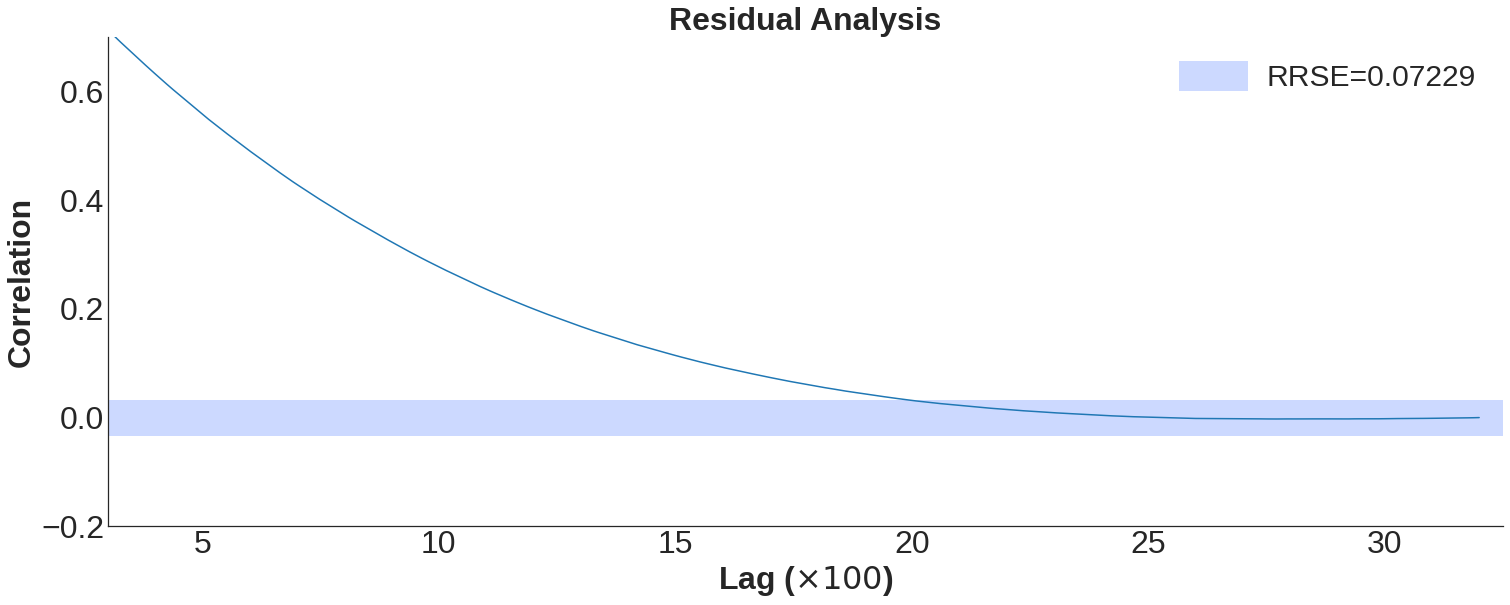

In [20]:

# plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
n=100
style="seaborn-white"
facecolor="white"
title="Residual Analysis"
ylabel="Correlation"
fontdict = dict(weight='bold', size=32)

plt.style.use(style)
plt.rcParams["axes.facecolor"] = facecolor
plt.figure(figsize=(25,9), facecolor="white")
T = np.linspace(0, len(ee[0]), len(ee[0]))
T /= 100
plt.plot(T, ee[0], color="#1f77b4")

ax = plt.gca()
ax.axhspan(ee[1], ee[2], color="#ccd9ff", alpha=1, lw=9, label="RRSE=0.07229")
ax.set_xlabel(rf"Lag ($\times 100$)", fontdict=fontdict)
ax.set_ylabel(ylabel, fontdict=fontdict)
ax.tick_params(labelsize=fontdict["size"])
ax.set_ylim([-0.2, 0.7])
ax.set_xlim([3, 32.5])
plt.legend(loc="upper right", fontsize=30)
ax.set_title(title, fontdict=fontdict)
plt.savefig(join(expanduser("~"),"Documents/Papers/Pubs22/IFAC/figures", "residue.eps"), dpi=79, facecolor=None)
plt.show()


### Find Equilibrium Point

+ Given certain initial conditions in $x_0$, $u_0$ and $z_0$, find all points in the state space that satisfy these equilibrium points 
via multivariate optimization using Powell method. 

In [21]:
# eq_pts = find_eq(narmax_model, [20], [0, 40, 0], z0=[20])#, iu=[1,2])
# print(rf"eq_pts: {eq_pts}")
 
# from math import pi
# import control as ct

# vehicle = ct.NonlinearIOSystem(
#     narmax_model, None, name='vehicle',
#     inputs = ('u', 'gear', 'theta'), outputs = ('v'), states=('v'))


# # Define the time and input vectors
# T = np.linspace(0, 25, 501)
# vref = 20 * np.ones(T.shape)
# gear = 4 * np.ones(T.shape)
# theta0 = np.zeros(T.shape)

# # Find the equilibrium point for the system
# Xeq, Ueq = ct.find_eqpt(
#     vehicle, [vref[0]], [0, gear[0], theta0[0]], y0=[vref[0]], iu=[1, 2])
# print("Xeq = ", Xeq)
# print("Ueq = ", Ueq)    

In [22]:
from math import pi 
import scipy as sp 

# Define the time and input vectors
T = np.linspace(0, 25, 501)
vref = 20 * np.ones(T.shape)
gear = 4 * np.ones(T.shape)
theta0 = np.zeros(T.shape)

xeq, ueq, weq = [20], [0.16874874, 40], [0]
theta_hill = [
    0 if t <= 5 else
    4./180. * pi * (t-5) if t <= 6 else
    4./180. * pi for t in T]

# solve for control w/our method here and plot I/O response

### System Response around equilibrium point (no control)


In [23]:
x0, u0, w0 = [20], [0.16874874, 40, 0], [0, 0]

A, B1, B2, C, D = linearize(x0, u0, w0)

# since we are only controlling the speed, pick B1 and B1's state components only
B1, B2, D = np.expand_dims(B1[:,0], 1), np.expand_dims(B2[:,0], 1), np.expand_dims(D[:,0], 1)

In [24]:

# pick an hinf norm bound gamma = 0.01

# with eigen placements, generate a series of stabilizing gains
possible_poles = range(-100, 0, 1)
possible_placements = [np.nan for x in range(len(possible_poles))]
Gains = [np.nan for x in range(len(possible_poles))]
Tzw = [np.nan for x in range(len(possible_poles))]
gammas = [np.nan for x in range(len(possible_poles))]

i = 0
for pole in possible_poles:
    possible_placements[i] = np.atleast_1d(np.squeeze(np.asarray(pole)))
    Gains[i] =  place_poles(A, B1, possible_placements[i], method='YT').gain_matrix

    # # for each computed gain, compute the closed loop transfer function over range of frequencies yet to be determined
    Tzw[i] = lambda w: (C - D@Gains[i])@la.pinv(1j*w - A + B1 * Gains[i])@B2

    # compute the starting value for gamma_lb
    gammas[i] = get_hinf_norm(A, B1, B2, C, D, Gains[i]).item()
    # print(pole, sla.eig(A-B1@Gains[i])[0])
    

    i += 1

INFO:Substituting symbol H from STIXNonUnicode
INFO:Substituting symbol H from STIXNonUnicode
INFO:Substituting symbol H from STIXNonUnicode
INFO:Substituting symbol H from STIXNonUnicode


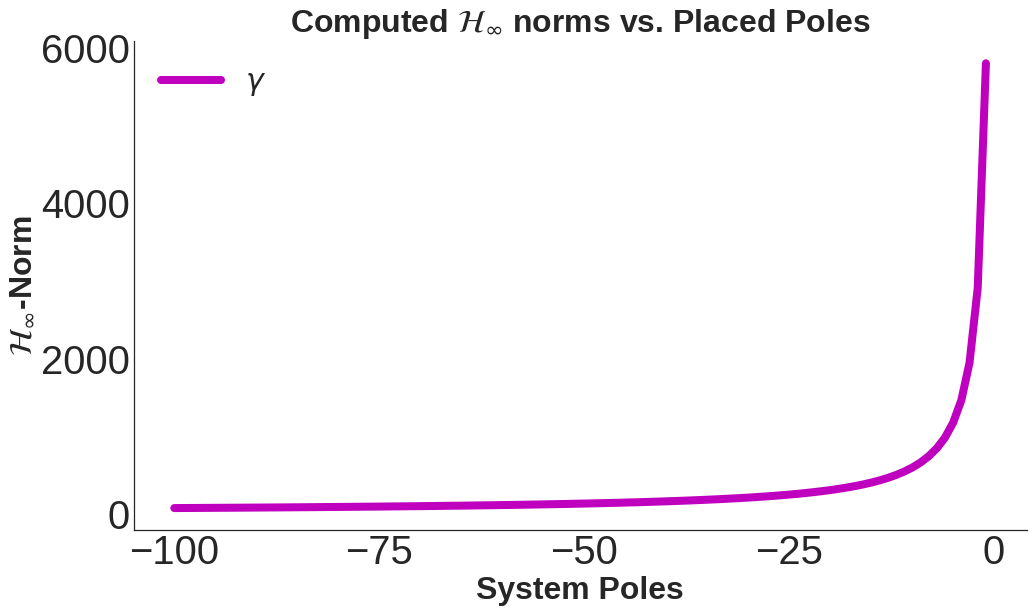

In [86]:
# Kplot = la.norm(np.array(Gains).squeeze(), ord=2, axis=1)
show = False 
fig = plt.figure(figsize=(16,9), facecolor="white")
ax  = plt.subplot(111)
ax.plot(possible_poles, np.asarray(gammas), label=rf"$\gamma$", linewidth=8, color="m")
ax.set_xlabel("System Poles", fontdict=fontdict)
ax.set_ylabel(r"$\mathcal{H}_\infty$-Norm", fontdict=fontdict)
ax.set_title(r"Computed $\mathcal{H}_\infty$ norms vs. Placed Poles", fontdict=fontdict)
ax.xaxis.set_tick_params(labelsize=40)
ax.yaxis.set_tick_params(labelsize=40)
ax.xaxis.set_ticks([-100, -75, -50, -25, 0])
# ax.yaxis.set_ticks([700, 12000, 18000])
ax.legend(loc="upper left", fontsize=30)
if show:
    plt.savefig(join(expanduser("~"),"Documents/Papers/Pubs22/IFAC/figures", "hinfs.eps"), dpi=79, facecolor=None)
plt.show()

### Collect (X, U) data and form $\Phi$ and $\Psi$ -- Equations (27)-(28) in paper.

In [26]:

# find which of these stabilizing gains simulataneously satisfy the H infinity norm bound for the system before we roll the algo forward
gammas = np.array(gammas)
safe_gamma_idx = np.where(gammas>1000)
safe_gamma = gammas[np.where(gammas>1000)][0]

Gains = np.array(Gains)
K1 = Gains[safe_gamma_idx][0]
# set up system

sys = Bundle(dict(A=A, B1=B1, B2=B2, C=C, D=D, tf=150, dt=0.1, Q=C.T@C, R=D.T@D ))

T = int(sys.tf/sys.dt)     # number of simulation timesteps
T = np.linspace(0, T, T)
X0 = np.array(([40]))  # collect data 
x, u, z = sys_integrator(sys, X0, K1, T)

Phi = np.zeros((3, 3))
Psi = np.zeros((3))

for i in range(u.shape[0]-1):
    kron_term = 2*kron(x[i,:].T, u[i,:].T)
    phi = np.array([(vecv(x[i,:]).T)[0], kron_term[0], 1])
    phi = np.expand_dims(phi, 1) 
    temp = phi@phi.T*sys.dt
    # print("temp: ", temp.shape)
    Phi += temp

    # psi now 
    Psi += phi@(vecv(x[i+1,:])-vecv(x[i,:])).T

Phi /= sys.tf
Psi /= sys.tf 
PhiInv = la.inv(Phi)

# Divide up the data 
n = 1; m = 1; n1 = int(n*(n+1)/2); n2 = int(n1 + m*n);

Phi_1_bar = PhiInv[:n1]
Phi_2_bar = PhiInv[n1:n2]

print("Phi_1_bar, Phi_2_bar, Psi ", Phi_1_bar.shape, Phi_2_bar.shape, Psi.shape)

Phi_1_bar, Phi_2_bar, Psi  (1, 3) (1, 3) (3,)


### Now Solve for Robust Controller

In [42]:
def iterative_robust(A, B1, B2, K1, gamma, Phi1, Phi2, Psi, PIter=40, QIter=80):

    n = A.shape[0]
    K = np.zeros((PIter,)+(K1.shape))
    K[0,:] = K1
    Rmat = np.eye(K1.T.shape[-1])
    P = np.zeros((PIter, QIter, n,n))


    for p in range(1, PIter):
        L = np.zeros((QIter, B2.shape[0], A.shape[0]))
        for q in range(QIter):
            t1 = Phi1@Psi 
            t2 = smat(kron(np.eye(n), K[p-1,:].T) + kron( K[p-1,:].T, np.eye(n)) )@Phi2@Psi 
            t3 = smat(kron(np.eye(n), L[q-1, :].T@B2.T) + kron( L[q-1, :]@B2.T, np.eye(n)))

            Upsilon = t1 - t2 + t3

            Qp = C.T@C - K[p-1,:].T@Rmat@K[p-1,:]

            P[p,q] = la.pinv(Upsilon)@svec(Qp - (1/(gamma**2))*L[q-1,:].T@L[q-1,:])
            L[q-1,:] = gamma**(-2)*B2.T@P[p,q]
        K[p, :] = la.pinv(Rmat)*B1.T@P[p, q]

    return K, L, P

### Solve the Riccati Equation (almost) analytically.

In [108]:
PIter, QIter = 20, 25 
Rmat = np.eye(K1.T.shape[-1])
Q = C.T@C 
safe_gamma = 500

# compute Popt via iDG synthesis 
KItr, LItr, PItr = iterative_robust(A, B1, B2, K1,  safe_gamma, Phi_1_bar, Phi_2_bar, Psi, PIter=40, QIter = 80)

# compute Popt via solve_care 
Popt, Kopt, Lopt = solve_care(A, B1, B2, Q, Rmat, safe_gamma)

In [109]:
# compute P's relative error
Pnorm = np.zeros((PIter, 1))
for piter in range(PIter):
    Pnorm[piter] = la.norm(PItr[piter,-1,0,0]- Popt, ord='fro' )/la.norm(Popt, ord='fro')

# compute Gain's relative error over time 
Knorm = np.zeros((PIter,1))
for piter in range(PIter):
    Knorm[piter] = la.norm(KItr[piter,0,0]- Kopt, ord='fro' )/la.norm(Kopt, ord='fro')

# solve for the H infinity norm error 
Hnorm = np.zeros((PIter,1))
for piter in range(PIter):
    Hnorm[piter] =  get_hinf_norm(A, B1, B2, C, D, KItr[piter]).item()

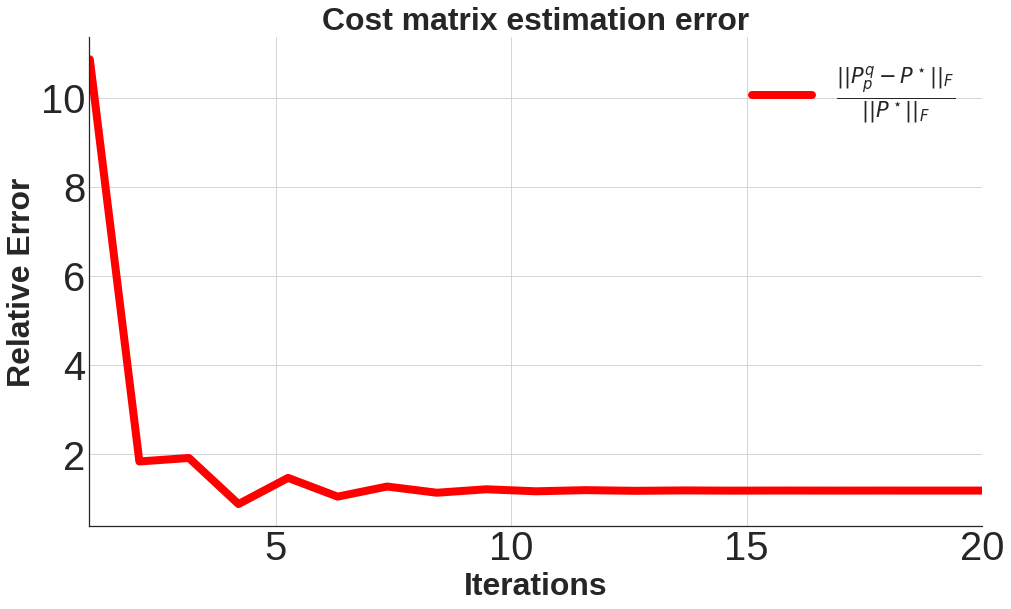

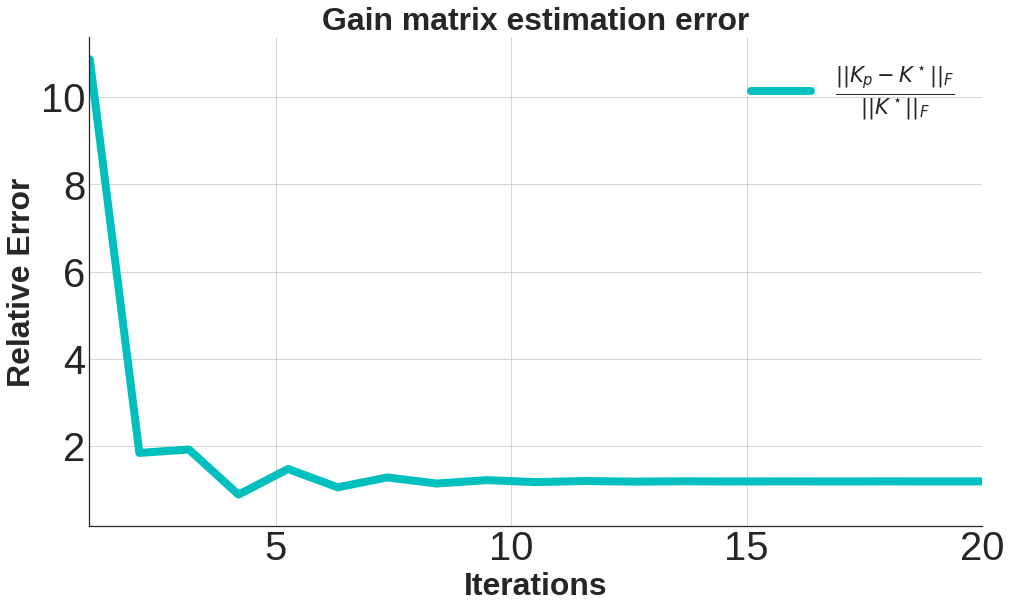

INFO:Substituting symbol H from STIXNonUnicode
INFO:Substituting symbol H from STIXNonUnicode
INFO:Substituting symbol H from STIXNonUnicode
INFO:Substituting symbol H from STIXNonUnicode
INFO:Substituting symbol H from STIXNonUnicode
INFO:Substituting symbol H from STIXNonUnicode
INFO:Substituting symbol H from STIXNonUnicode
INFO:Substituting symbol H from STIXNonUnicode
INFO:Substituting symbol H from STIXNonUnicode


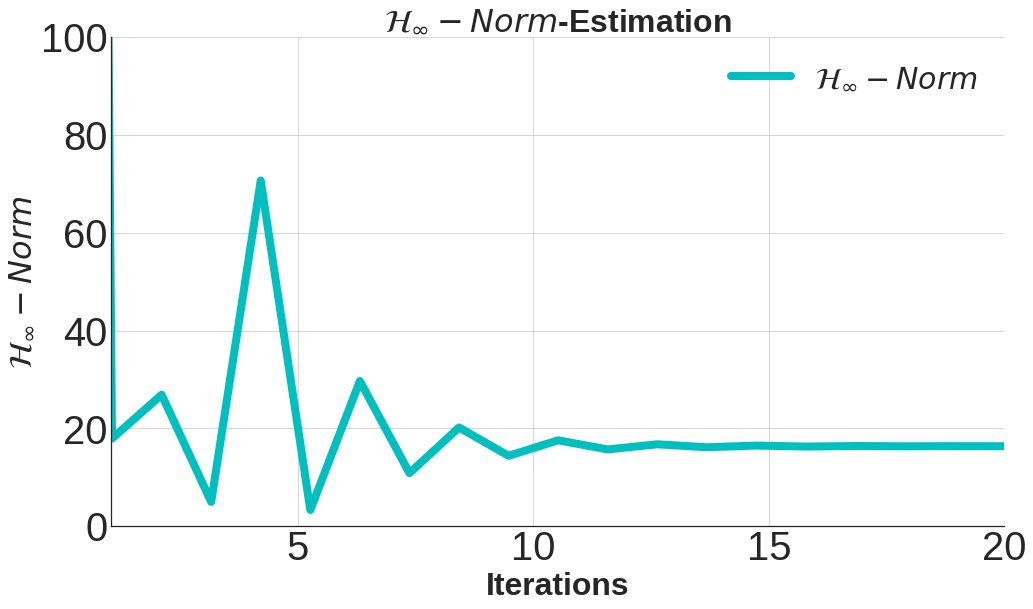

In [112]:
# show me what you got
show = True 
fig = plt.figure(figsize=(16,9), facecolor="white")
ax  = plt.subplot(111)
xlim_start = 1.04
T = np.linspace(0, PIter, PIter)

# pl.ot the cost matrix
ax.plot(T, Pnorm, label=r"$\frac{\||P_p^q - P^\star\||_F}{\||P^\star\||_F}$", linewidth=8, color="r")
ax.set_xlabel("Iterations", fontdict=fontdict)
ax.set_ylabel(r"Relative Error", fontdict=fontdict)
ax.set_title(r"Cost matrix estimation error", fontdict=fontdict)
ax.grid("on")
ax.set_xlim([1.04,PIter])
ax.xaxis.set_tick_params(labelsize=40)
ax.yaxis.set_tick_params(labelsize=40)
ax.legend(loc="upper right", fontsize=30)
if show:
    plt.savefig(join(expanduser("~"),"Documents/Papers/Pubs22/IFAC/figures", "cost_mat.eps"), dpi=79, facecolor=None)
plt.show()

# pl.ot the gain matrix
fig = plt.figure(figsize=(16,9), facecolor="white")
ax  = plt.subplot(111)
T = np.linspace(0, PIter, PIter)
ax.plot(T, Knorm, label=r"$\frac{\||K_p - K^\star\||_F}{\||K^\star\||_F}$", linewidth=8, color="c")
ax.set_xlabel("Iterations", fontdict=fontdict)
ax.set_ylabel(r"Relative Error", fontdict=fontdict)
ax.set_title(r"Gain matrix estimation error", fontdict=fontdict)
ax.grid("on")
ax.set_xlim([1.04,PIter])
ax.xaxis.set_tick_params(labelsize=40)
ax.yaxis.set_tick_params(labelsize=40)
ax.legend(loc="upper right", fontsize=30)
if show:
    plt.savefig(join(expanduser("~"),"Documents/Papers/Pubs22/IFAC/figures", "gain_mat.eps"), dpi=79, facecolor=None)
plt.show()

# pl.ot the hinf matrix
fig = plt.figure(figsize=(16,9), facecolor="white")
ax  = plt.subplot(111)
T = np.linspace(0, PIter, PIter)
ax.plot(T, Hnorm, label=r"$\mathcal{H}_\infty-Norm$", linewidth=8, color="c")
ax.set_xlabel("Iterations", fontdict=fontdict)
ax.set_ylabel(r"$\mathcal{H}_\infty-Norm$", fontdict=fontdict)
ax.set_title(r"$\mathcal{H}_\infty-Norm$-Estimation", fontdict=fontdict)
ax.grid("on")
ax.set_xlim([1.04,PIter])
ax.set_ylim([0,100])
ax.xaxis.set_tick_params(labelsize=40)
ax.yaxis.set_tick_params(labelsize=40)
ax.legend(loc="upper right", fontsize=30)
if show:
    plt.savefig(join(expanduser("~"),"Documents/Papers/Pubs22/IFAC/figures", "h_norm_cruise.eps"), dpi=79, facecolor=None)
plt.show()

In [117]:
# solve for the system response with and without disturbance 
# Compute the steady state velocity and throttle setting
xd = xeq[0]
ud = ueq[0]
yd = vref[-1]

# Response of the system with no antagonistic player feedback term
plt.figure()
theta_hill = [
    0 if t <= 5 else
    4./180. * np.pi * (t-5) if t <= 6 else
    4./180. * np.pi for t in T]


In [118]:
yd

20.0